# IN-STK5000/9000 - Adaptive methods for data-based decision making
## Credit Project

The code to reproduce experiments can be found [here](https://github.com/gsel9/ml-society-science).

#### Syed Moeen Ali Naqvi - Geir Severin Rakh Elvatun Langberg - Markus Sverdvik Heiervang  
***

## Part 1: Banker agent
In this notebook, we display and comment on the development of our banker model, and measure it against the random banker, as well as documenting the implementations of the different methods used for the class

### Task 1 - Implementing expected utility

Our action space $\mathcal{A}$ is binary: $\mathcal{A} = \{0, 1\} = \{a_1, a_2\} = \{ \text{refuse_loan}, \text{grant_loan} \}$


To calculate the expected utility, we consider two actions: $a_1$ granting the loan or $a_2$ not granting a loan. Moreover, if granting a loan, the outcome at the end of the lending period $n$ is that it can be either fully repaid $\omega_1$ or not repaid $\omega_2$. The utility of granting a loan of $m$ credits that is also repaid is $m((1 + r)^n - 1)$, whereas, if the loan is not repaid, the utility is $-m$. In case of not granting the loan, the utility is zero. Thus, given the probability of being credit-worthy, $P(\omega_1)$, the expected utility is  


$$
    \mathbb{E}(U \mid a) = m((1 + r)^n - 1)P(\omega_1) - m(1 - P(\omega_1)).
$$

This calculation is implemented as follows


```Python
def expected_utility(self, x: pd.Series, action: int) -> float:

        if action:
            # Probability of being credit worthy.
            pi = self.predict_proba(x)

            return x["amount"] * ((1 + self.rate) ** x["duration"] - 1) * pi - x["amount"] * (1 - pi)

        return 0.0
```

### Task 2 - Implementing the fit function

We are using Random forest classifier to fit a model for calculating the probability of credit-worthiness for a creditor. Random forests (RF) construct many individual decision trees at training. Predictions from all trees are pooled to make the final prediction; the mode of the classes for classification. As they use a collection of results to make a final decision, they are referred to as Ensemble techniques.

We are using scikit-learn to implement the classifier. We have included optional hyper-parameter tuning before fitting the model.

Following is the code for fit():

```Python
    def fit(self, X: pd.DataFrame, y: pd.Series) -> None:
        if self.optimize:
            #Finding optimal paramters
            param_grid = [{
                'bootstrap' : [True],
                'max_features' : list(range(10,20,1)),
                'max_depth' : list(range(10,100,10)),
                'n_estimators' : list(range(25,150,25))
            }]

            grid_search = GridSearchCV(
                    estimator = RandomForestClassifier(), param_grid = param_grid, cv = 5
            )
            grid_search.fit(X, y)
            self.classifier = RandomForestClassifier(
                random_state=self.random_state, **grid_search.best_params_
            )
        else:
            self.classifier = RandomForestClassifier(
                n_estimators=100,
                random_state=self.random_state,
                class_weight="balanced"
            )
            
        self.classifier.fit(X,y)

```

The method predict_proba() ensures that the fit() is called beforehand and predicts the probability of the loan being returned. 

Following is the code for predict_proba():

```Python
    def predict_proba(self, x: pd.Series) -> float:
        if not hasattr(self, "classifier"):
            raise ValueError("This Group4Banker instance is not fitted yet. Call 'fit' "
                             "with appropriate arguments before using this method.")

        x_reshaped = np.reshape(x.to_numpy(), (1,-1))

        return self.classifier.predict_proba(x_reshaped)[0][0]
```

We are assuming that the labelling process is correct and the labels represent the ground truth. 

### Task 3 - Get best action


Assuming that we are maximising utility, a general function would be

$$
\text{best_action}(x) = \underset{a \in \mathcal{A}}{\text{argmax}} \  \mathbb{E}(U \mid a)
$$

but since our action space is binary, it can be expressed as

$$  
\text{best_action}(x) = \begin{cases}
    1,& \text{if } \mathbb{E}(U \mid a=1) > 0\\
    0,              & \text{otherwise}
\end{cases}
$$

We can translate this into python code as such:

```Python
def get_best_action(self, x: pd.Series) -> int:
        return int(self.expected_utility(x, 1) > 0)
```

### Task 4 - Documenting the banker  

For this part, we'll be interacting with the Group4Banker in the cells below. 
Before measuring the performance, we conduct a series of unit tests to assert that each method works for a few cases

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import unittest
import shap

from group4_banker import Group4Banker
# temporary import for simplicity/dev
#TODO: Make all imports explicit
from test_biases import *
from test_lending import setup_data
from test_group4_banker import TestGroup4Banker
# seed for reproducibility
np.random.seed(42)

In [2]:
# We'll need these arguments when running the tests in jupyter notebook
unittest.main(argv=["first-arg-is-ignored"], exit=False)

.....
----------------------------------------------------------------------
Ran 5 tests in 1.695s

OK


We rewrote the TestLending script into a neat command-line interface so that we can customize the programs parameters.   
This will also display progress of the training, since the classifier might take some time.  

From this, we can observe that our banker performs better than the RandomBanker

In [3]:
# !python3 test_lending.py ../../data/credit/D_valid.csv --n-tests 100 --seed 12 --interest-rate 0.05 --random_banker
!python3 test_lending.py ../../data/credit/D_valid.csv --n-tests 10 --seed 12 --interest-rate 0.05 --random_banker

Running with random seed:  12
r=0.05, n_tests=10, seed=12

Testing on class: RandomBanker ...
100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 19.34it/s]
Results:
	Average utility: 2500706304.100619
	Average return on investment: 30721.427088870863

Testing on class: Group4Banker ...
100%|███████████████████████████████████████████| 10/10 [00:23<00:00,  2.40s/it]
Results:
	Average utility: 286314977457.0404
	Average return on investment: 6291933.651607041


Let's see how our banker performs on the training set

In [4]:
# !python3 test_lending.py ../../data/credit/D_train.csv --n-tests 100 --seed 11 --interest-rate 0.05 --random_banker
!python3 test_lending.py ../../data/credit/D_train.csv --n-tests 10 --seed 11 --interest-rate 0.05 --random_banker

Running with random seed:  11
r=0.05, n_tests=10, seed=11

Testing on class: RandomBanker ...
100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 18.77it/s]
Results:
	Average utility: 474570968079.96985
	Average return on investment: 16027708.34969331

Testing on class: Group4Banker ...
100%|███████████████████████████████████████████| 10/10 [00:24<00:00,  2.45s/it]
Results:
	Average utility: 420696409166.38293
	Average return on investment: 7860905.078636621


## Part 2: Reliability, privacy and fairness

### 2.1 Model reliability

Is it possible to ensure that your policy maximises revenue? How can you take into account
the uncertainty due to the limited and/or biased data? What if you have to decide for credit
for thousands of individuals and your model is wrong? How should you take that type of
risk into account?

In general, we cannot ensure that the policy maximises revenue because the probability estimates $P(\omega_1)$ and $P(\omega_2)$ about the outcome of events $\omega_1$ and $\omega_2$ might be biased. However, from a theoretical point of view where we assume $P(\omega_1)$ and $P(\omega_2)$ are true, to maximize revenue we desire 

$$
    \mathbb{E}(U \mid a) > 0 \Rightarrow m((1 + r)^n - 1)P(\omega_1) > mP(\omega_2) \Leftrightarrow (1 + r)^n - 1 > \frac{P(\omega_2)}{P(\omega_1)}, \quad P(\omega_1) > 0
$$

To select parameters $n$ and $r$ ensuring $\mathbb{E}(U \mid a) > 0$ we can either consider 

$$
    n > \frac{\ln P(\omega_2) - \ln P(\omega_1)}{\ln (1 + r)}, \quad r, P(\omega_1), P(\omega_2) > 0
$$

for fixed $r$, or 

$$
r > \exp\left ( \frac{\ln P(\omega_2) - \ln P(\omega_1)}{n} \right ) - 1, \quad n, P(\omega_1), P(\omega_2) > 0
$$

for fixed $n$.

---


To obtain a model performance measure that is more robust than a single point estimate, one can consider a re-sampling technique - such as cross-validation of bootstraping - to derive an empirical distribution of performance. In our approach, we use bootstraping to predict the optial actions on several random subsets of the test data. This produces a matrix $\mathbf{\hat{Y}} \in \left \{ a_0, a_1 \right \}^{N \times M}$ of predicted actions on $N$ bootstrap samples of size $P$. Note that the predicted actions corresponds to the ground truths $\mathbf{Y}$ in the test data.


--- 

We use a Bayesian approach to evaluate the effect of an increasing number of samples on the model by comparing the posterior probability of rejecting $a_0$ (grant loan) when $a_1$ (don't grant loan) is true, to a ground truth derived from the test data. That is, we evaluate the model's ability to reject a loan that is unlikely to be repaid. The reference rejection rate $\hat{\mu}$ of $H_0$ is computed from the test data bootstrap samples

$$
\hat{\mu}_0 = \frac{1}{NM} \sum_{n, m} \mathbb{I}(Y_{n, m} = 0)
$$

Moreover, assuming $Y_{n, m}$ are i.i.d., we include a $1 - \delta$ confidence interval around $\hat{\mu}_0$ by using Hoeffding's inequality 
$$
    \left | \hat{\mu}_0 - \mathbb{E}\left \{ \hat{\mu}_0 \right \} \right | \leq \sqrt{\frac{\ln2 \delta}{2n}} \Rightarrow \mathbb{E}\left \{ \hat{\mu}_0 \right \} \in \left [ \hat{\mu}_0 - \sqrt{\frac{\ln2 \delta}{2n}}, \hat{\mu}_0 + \sqrt{\frac{\ln2 \delta}{2n}} \right ],
$$
bounding the expected value of $\hat{\mu}_0$. 

In experiments, we ran 500 iterations of 50 bootstrap samples for $\delta = 0.05$. The code to reproduce our experiments can be found in `action_sensitivity.py`. 

In the following figure, we compare the probability of accepting $H_0$ given model esimtates to the reference rate $\hat{\mu}_0$ derived from test data. The figure shows that the probability of granting a loan that will not be repaid converges to $\hat{\mu}_0$ as the number of boostrap samples increases.

In [5]:
from IPython.display import IFrame

IFrame("posterior_null_hypo.pdf", width=800, height=500)

To further enhance model performance, we can update our prediction model providing probability estimates by including more *Decision Trees* in the *Random Forest*. The additional trees are then trained on the test data after predictions are performed. This mechanism could be implemented as follows:

```Python
def adaptive_predict_proba(X, y, n_extra_estimators=0):
    """Use test data to re-train the model after each decision."""
    
    y_pred = model.predict_proba(X)
    
    # Add more decision trees to the model and train these using the new training data.
    model.set_params(n_estimators=int(model.n_estimators) + int(n_extra_estimators), warm_start=True)
    model.train(X, y)
        
    return y_pred
```

### 2.2 Data privacy

Does the existence of this database raise any privacy concerns? If the database was secret
(and only known by the bank), but the credit decisions were public, how would that affect
privacy? (a) Explain how you would protect the data of the people in the training set. (b)
Explain how would protect the data of the people that apply for new loans. (c) Implement
a private decision making mechanism for (b),3 and estimate the amount of loss in utility
as you change the privacy guarantee.

The database contains information about individuals such as sex, age, personal status, employment status, property, housing status which can be used to identify individuals when linked with other publicly available databases (e.g., social media, tax data, health records, voter's data, etc). If the data is available publicly, a linkage attack can be used to identify many individuals in this database. 

If the database was secret (and known only by the bank), but the credit decisions were public, the overall privacy of the data will definitely increase. However, an attacker can still infer information based on the published credit decisions depending on how the decisions are published. For example, if credit decision include data about the amount and duration of loan, and an attacker already knows certain attributes of an individual, it is possible to identify an individual.


The training set data of people in the database can be protected by adopting the randomized response mechanism (i.e. Global privacy model). For that, we return the true credit decision with probability $\leq 1$. The calculation of each response would not be dependent on the query. 

Whether someone who doesn't already exist in our database, or someone who has some history with the considered credit system, the information provided is sensitive and it needs to be randomized. For that, we can transform each attribute independently by adding a noise to it (i.e. local privacy model). This can be represented as:

$$
\pi(a|x) = \underset{i}{\Huge \Pi} \pi(a_i|x_i)
$$
   
where $x$ represents the complete data and $a = (a_1,.....,a_n)$ represents the mechanism's output. The method is $\epsilon-$differentially private.

We are using localized privacy model for our private decision making mechanism. We have used Laplace transformation for the numerical features in our data. It is defined as: 

$$
\pi(a|x) = Laplace(f(x), \lambda)
$$ 

for any function $f: \chi \to \mathbb{R}$ where Laplace density is defined as: 

$$
\rho(\omega | \mu, \lambda) = \frac{1}{2\lambda}exp(-\frac{|\omega - \mu|}{\lambda})$$
with mean $\mu$ and variance $2\lambda^2$.

For the categorical features, we have used the randomized response for a certain probability.

Our implementation for the randomize_data() is as follows:


```Python
def randomize_data(data: Tuple[pd.DataFrame, Dict[str, Any]],
                   probability: float, laplace_delta: float) -> pd.DataFrame:
    X, feature_data = data
    categorical_features = feature_data["encoded_categorical_features"]
    numerical_features = feature_data["numerical_features"]
    X_random = X.copy()

    for column_name in categorical_features:
        temp_col = X_random[column_name]
        random_index = np.random.choice([True,False], temp_col.size,
                                        p=[probability, 1-probability])

        new_datapoints = np.random.choice(np.unique(temp_col), random_index.sum())
        temp_col[random_index] = new_datapoints
        X_random[column_name] = temp_col


    for column_name in numerical_features:
        temp_col = X_random[column_name]
        noise = np.random.laplace(0, laplace_delta, size=temp_col.size)
        noise *= temp_col.std()
        X_random[column_name] = temp_col + noise

    return X_random
```


The exponential mechanism defines the utility of a query $q$ for a user $x$ with a response $a$ as:

$$
\pi(a|x) = \frac{e^{\epsilon U(q,a,x) / \Delta U}}{\sum_{a'}e^{\epsilon U(q,a',x) / \Delta U}}
$$

where $\Delta U = sup_{xNx'}|U(q,a,x) - U(q,a,x)|$

where the lower the value of $\epsilon$, the more randomized a result would be.

For calculating the loss in utility according to privacy, we can come up with the formula: 

$$
\Delta U = Utility_{x, original} - Utility_{x, private}
$$




In [6]:
# !python3 test_lending.py ../../data/credit/D_valid.csv --n-tests 100 --seed 12 --interest-rate 0.05 --randomize 0.5 1
!python3 test_lending.py ../../data/credit/D_valid.csv --n-tests 10 --seed 12 --interest-rate 0.05 --randomize 0.5 1

Running with random seed:  12
r=0.05, n_tests=10, seed=12
probability: 0.5, laplace delta: 1.0
test_lending.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_col[random_index] = new_datapoints

Testing on class: Group4Banker ...
100%|███████████████████████████████████████████| 10/10 [00:24<00:00,  2.46s/it]
Results:
	Average utility: 199528001452.54364
	Average return on investment: 3783143.523795292

Testing on class: Group4Banker ...
100%|███████████████████████████████████████████| 10/10 [00:25<00:00,  2.52s/it]
Results:
	Average utility: 13070364691.792656
	Average return on investment: 238803.97669817525


## 2.3 Model fairness
Is our banker model fair? What interesting features does it consider? Consider the model with repsect to Group fairness and conditional independece: Does is evaluate on fair grounds? Can this model be subject to discrimination? What can you say about the fairness with respect to Individual Independence and Meritocracy?

***  

### Feedback  

+ Nice documentation overall + Correct implementation o fexpected utility + Good use of grid search in fit function! + Correct best action 

Moeen: + Good explanation of LDP ? What is the point of the exponential mechanism here? Note that the LU in the exponential mechanism is simply how much the utility changes if one input changes, i.e. the sensitivity of the utility funciton. Your Delta U is something entirely different. As far as I can tell you are not using the exponential mechanism anywhere.   

Markus: + Good observation about male/female - You probably need to perform a more thorough analysis of fairness (i.e. consider different aspects of fairness and calculate them numerically/with histograms etc)

---

different aspects of fairness:
meritocracy  
proportionality and representation  
equal treatment  
non-discrimination


***  

# Part 3: Evaluation, fairness and policy optimization

Choose one concept of fairness, e.g. balance of decisions with respect to gender. How can you
measure whether your policy is fair? How does the original training data affect the fairness of your policy? To help you in this part of the project, here is a list of guiding questions.   
  
• Identify sensitive variables. Do the original features already imply some bias in data collection?

Looking at the dataset, typical necessary features would be credit history, 
amount and lending period. 
However, some of the features seem to look at details about the person
that might just be loosely connected to return of loan. 
The features age, phone, foreign and sex/status are all taken into account when the model evaluates, which means that it can generate biases on these grounds.
So we have to talk about which biases are fair, and which we might want to avoid.

We assume that for every individual t, we have a set of relevant information: $x_t$, a set of sensitive information $z_t$ and a potential (or prior) outcome $y_t$.  

Differentiating between $X$ and $Z$ is a non-trivial task might require domain knowledge or opinion-based decisions.
So what we can do is to decide $Z$ ourselves and assume that it is correct.
Let $Z$ then be the set over the following attributes in our dataset:

$$
Z = \{
sex,  
marital status,  
age,  
foreign,  
job,  
phone,  
\}
$$
It is important to undestand that in this case, $Z_t \cap X_t \neq \emptyset$ as we will see later on that some of these features significantly affect the decision function

The sex/status attribute is defined as such
     
```console
Attribute 9:  (qualitative)
	      Personal status and sex
	      A91 : male   : divorced/separated
	      A94 : male   : married/widowed
	      A92 : female : divorced/separated/married
          A93 : male   : single
	      A95 : female : single    
```
(from the dataset description in data/credit/german.doc)

What is interresting to see here is that there are more categories for male than female.
Male+divorced/separaeted is a different category than male+married/widowed, but when it comes to female, these categories are merged into one. Why is that? Could it be because we're compensating for missing data? Or are we making assumptions about how this affects the likelihood of returning loan?

Because we are talking about loan and maximizing revenue, this model has to discriminate on some grounds, such as social class (e.g. job/salary). 
The ability to take a loan is something that directly affects your opportunities in society. If equal opportunity for, say gender, is something we strive for, it is important to ensure that that there is no bias on gender alone in the model, even if costs us utility. Since this attribute is part of the data we're training on, the model is (almost) guaranteed to have some, though possibly microscopical, bias with respect to sex. If we want to remove this bias, we should drop information about sex from the dataset, and instead, only use the categorical features married, divorced, widowed, single. Otherwise, we can inspect our probabilistic model to see how this actually is affected.  
  
  
We base our decision maker on maximizing utility, which gives us an inherently meritocratic policy once we assure conditional independence for some sensitive variables. 
The only thing left to worry about is the correctness of the utility function. We assume the given utility function to be correct for this task.  
A general problem about the meritocratic fairness is that we base it on equal opportunity: essensially that we make a very bold assumption that everyone have had equal opportunities to get the salaries they have in the dataset.

• Analyse the data or your decision function with simple statistics such as histograms.
  

Let's try to visualize the distribution of genders and marital statuses. For this, we can use a simple barchart

In [7]:
# We use the utilities from test_biases to map encoded columns to descriptive names and vice versa
single_male = description_feature["single male"]
single_female = description_feature["single female"]

In [8]:
dataset, feature_data = setup_data("../../data/credit/D_train.csv")
encoded_features, target = feature_data["encoded_features"], feature_data["target"]
X = dataset[encoded_features]
y = dataset[target]

def get_returns_on_feature(feature, data, target, feature_value=1):
    data = data[data[feature] == 1]
    positives, negatives = data[target] == 1, data[target] == 2
    return positives.sum(), negatives.sum()

get_returns_on_feature(single_male, dataset, target)

(178, 77)

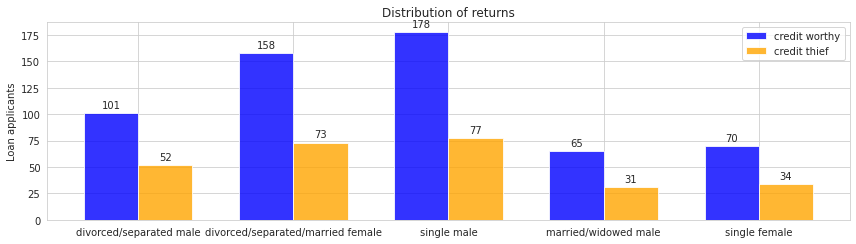

In [9]:
Y1, Y0 = np.zeros(5, dtype=int), np.zeros(5, dtype=int)
marital_statuses = [f"marital status_{i}" for i in range(1, 6)]
for i, field in enumerate(marital_statuses):
    Y1[i], Y0[i] = get_returns_on_feature(field, dataset, target)
feature_descriptions = [feature_description[i] for i in marital_statuses]
credit_worthiness_barchart(Y1,Y0,feature_descriptions, figsize=(12, 3.5))

From this chart, we see that though the demographics vary in sample sizes, the proportion credit return and theft seems even among all of these particular classes (not to be confused with the classes of our classification problem). Keep in mind that this is from the train set, meaning that it is possible that these datapoints are chosen carefully to initally increase conditional independence between these features. If we look at the proportions, we get a general idea of how this could affect the decision rule by looking at the proportions.

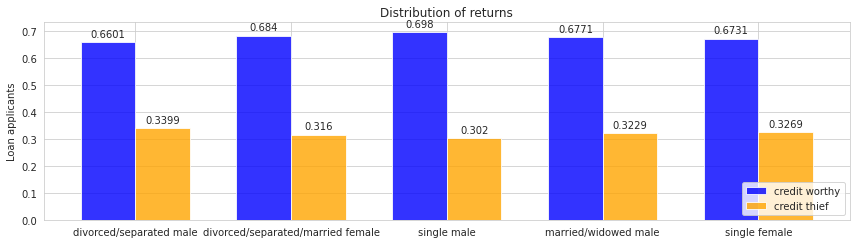

In [10]:
Y1_norm = (Y1/(Y0+Y1)).round(4)
Y0_norm = (Y0/(Y0+Y1)).round(4)
credit_worthiness_barchart(Y1_norm, Y0_norm , feature_descriptions, figsize=(12, 3.5), legend_anchor=4)

The propotions are very similiar for all the demographics. However, even a microscopical difference can imply some bias.  
Running the bias test below will show that our probabilistic model varies in bias, favoring each sex in diffrerent scenarios

In [11]:
!python3 test_biases.py --seed 43

Proportion of returns for single males in the train set:
 0.6980392156862745
Proportion of returns for single females in the train set:
 0.6730769230769231 

Estimated probability for single male: 0.52 
Estimated probabiltiy for single female: 0.54 
Absolute difference 0.020000000000000018 

Estimated probability for single male: 0.54 
Estimated probabiltiy for single female: 0.54 
Absolute difference 0.0 

Estimated probability for single male: 0.83 
Estimated probabiltiy for single female: 0.82 
Absolute difference 0.010000000000000009 



To test whether the biases can have any effect on the decision making, we can test it by comparing estimated probabilities of single women compared to single men.

The difference in probability estimates is microscopical, but still exsistent.  
We can create an edge-case where the decisions would be different.

In [12]:
decision_maker = get_trained_model(0.05)
categories = get_encoded_features()

# hand picked features for edge-case evaluation
values = [26.5, 25938, 7, 2, 38, 0, 6, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 
          0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

x_male = pd.Series(dict(zip(categories, values)))
x_female = x_male.copy()
x_male[single_male], x_female[single_female] = 1, 1

print("Best action for single male:", decision_maker.get_best_action(x_male[categories]))
print("Best action for single female:", decision_maker.get_best_action(x_female[categories]))

Best action for single male: 1
Best action for single female: 0


As we can see here, though all the other features are identical, our banker will give loan to the single male, but not the single female. So our model can be subject to discrimination, though unlikely.

To look at unevenness in the dataset, we can create a histogram displaying genders in the dataset

analysis of data:
include proportions in train set, test set
analyse age, male female  
consider married features as well. Discuss possible issues with uneven feature distribution between male/female
analyse related marital statuses

analysis of decision function: shap

As we're basing our banker model on the random forest classifier for evaluating probability of credit worthiness, we will visualize the significance and sensitivity of each featrue using Shapley values. For this we'll be using the shap module which can easily be installed using pip:  
`pip3 install shap`

In [13]:
model = decision_maker.classifier
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

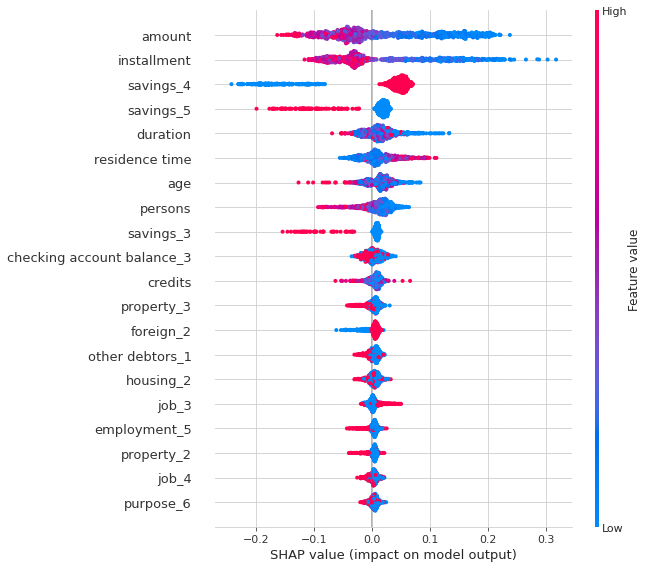

In [14]:
shap.summary_plot(shap_values[0], X)

From the plot we can see that the most important features directly regard the loan and other monetary fields. One feature that stands out from this is age. From this diagram,  has a considerable impact on the decision function. What we can interpret from this, is that higher loan amounts reduces likelihood of return according to our model, meaning that other features will have to compensate. Keep in mind that this only accounts for the probabilistic model, and not the utility calculation and the final decision function. We can see from the savings attributes that people with a lot of savings are more likely to return credit, whilst people with no savings account are less likely to return loan according to our model.
  
  
We can also use shap to explain certain decisions. For instance, take the fourth row in our train set:

In [27]:
shap.initjs()
i = 4; shap.force_plot(explainer.expected_value[0], shap_values[0][i,:], X.iloc[i,:])

In this example, the most important factor for predicting credit worthiness is residence time.  
And we can see that this was the correct prediction, as the person ended up returning the loan.

In [28]:
dataset[target].iloc[i]

1

In [30]:
i = 5; shap.force_plot(explainer.expected_value[0], shap_values[0][i,:], X.iloc[i,:])

In [31]:
dataset[target].iloc[i]

2

Now, for the more relevant measurements: let's look at the shap values for single male and female:

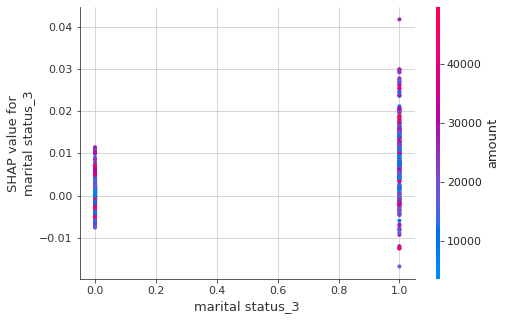

In [19]:
shap.dependence_plot(single_male, shap_values[0], X, interaction_index="amount")

The shap values for the single males (the vertical array of points on the right) show that the feature alone microscopically affects decisions (presumably in some combination with other features) mainly positively, but also in some cases negatively.

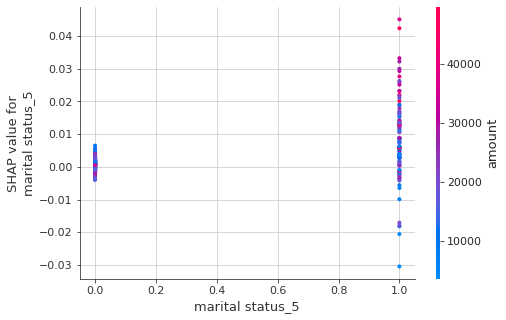

In [20]:
shap.dependence_plot(single_female, shap_values[0], X, interaction_index="amount")

The shap values here for single females are much more negative, and it also a clearer correlation between amount and shap value. It looks like being a single woman is beneficial when applying for higher loans, and less beneficial when applying for loans of low amounts

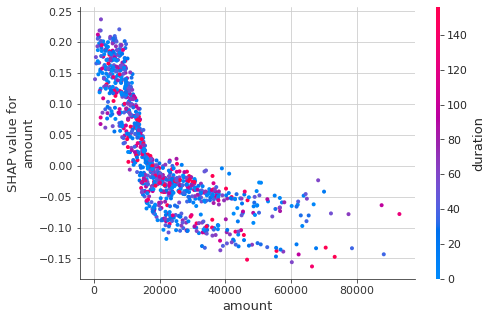

In [18]:
shap.dependence_plot("amount", shap_values[0], X, interaction_index="duration")

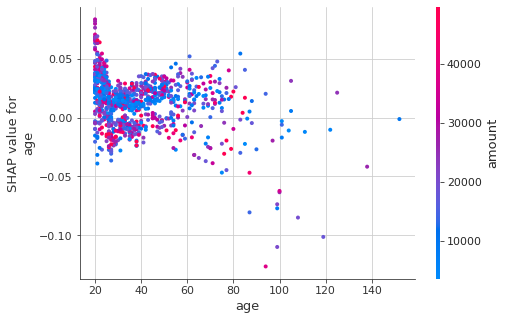

In [21]:
shap.dependence_plot("age", shap_values[0], X, interaction_index="amount")

In [ ]:
#? compute F_calibration, F_balance and F_merit from page 107

• For balance (or calibration), measure the total variation of the action (or outcome) distribution for different outcomes (or actions) when the sensitive variable varies.
  

`#TODO`
extend test biases to calculate balance and variation distribution

• Advanced: What would happen if you were looking at fairness by also taking into account
the amount of loan requested?
  

Text(0.5, 1.0, 'Single men best action (a)')

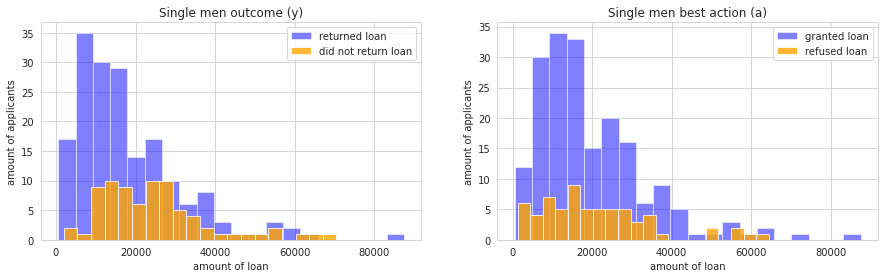

In [22]:
dataset, feature_data = setup_data("../../data/credit/D_train.csv")
encoded_features, target = feature_data["encoded_features"], feature_data["target"]
X = dataset[encoded_features]
y = dataset[target]
decision_maker = Group4Banker()
decision_maker.set_interest_rate(0.05)
decision_maker.fit(X, y)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
generate_histogram_action(decision_maker, dataset, feature_data, single_male, ax=ax2)
generate_histogram_outcome(decision_maker, dataset, feature_data, single_male, ax=ax1)
ax1.set_title("Single men outcome (y)")
ax2.set_title("Single men best action (a)")

Text(0.5, 1.0, 'Single women best action (a)')

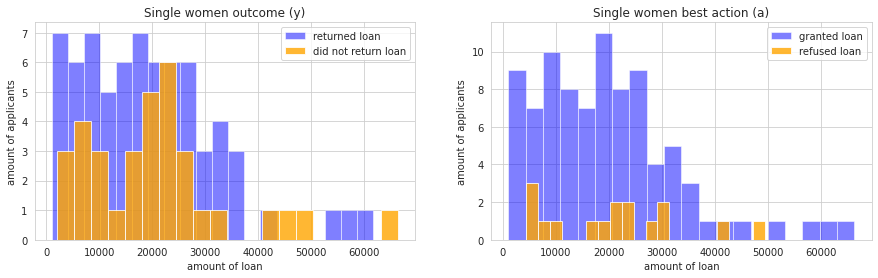

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
generate_histogram_outcome(decision_maker, dataset, feature_data, single_female, ax=ax1)
generate_histogram_action(decision_maker, dataset, feature_data, single_female, ax=ax2)
ax1.set_title("Single women outcome (y)")
ax2.set_title("Single women best action (a)")

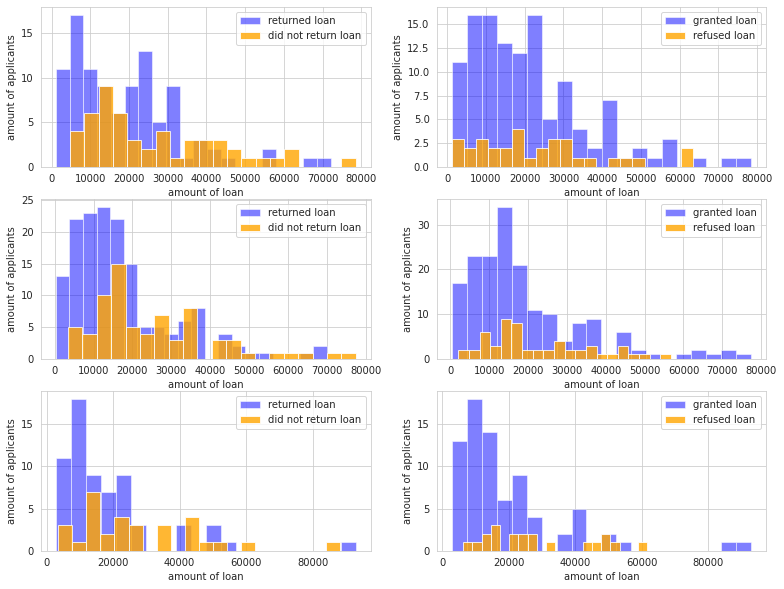

In [24]:
fig, axes = plt.subplots(3, 2, figsize=(13, 10))
for i, f in enumerate(["marital status_1", "marital status_2", "marital status_4"]):
    generate_histogram_outcome(decision_maker, dataset, feature_data, f, ax=axes[i][0])
    generate_histogram_action(decision_maker, dataset, feature_data, f, ax=axes[i][1])

overflow encountered in exp
overflow encountered in exp


Text(0.5, 1.0, 'Single women expected utility $\\mathbb{E}(U | x)$')

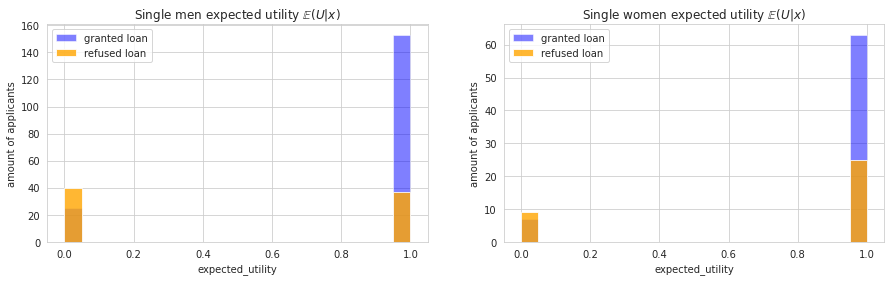

In [25]:
# TODO: histogram over utility: make this work
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
generate_histogram_utility(decision_maker, dataset, feature_data, single_male, ax=ax1)
generate_histogram_utility(decision_maker, dataset, feature_data, single_female, ax=ax2)
ax1.set_title(r"Single men expected utility $\mathbb{E}(U | x)$")
ax2.set_title(r"Single women expected utility $\mathbb{E}(U | x)$")

• Advanced: Using stochastic gradient descent, find a policy that balances out fairness and
utility.

Let 

$$
\pi_w(x) = \frac{\exp(w^\top x)}{\exp(w^\top x) + 1}
$$

be a policy parametrized by $w \in \mathbb{R}^n$, where $\pi_w$ indicates the probability of whether to grant or not grant a loan given some feature vector $x \in \mathbb{R}^n$. We remark that $\pi_w$ is differentiable by $\nabla_w \pi_w = x\exp(w^\top x) / (\exp(w^\top x)  + 1)^2$, making gradient based optimization a suitable approach to estimate $w$. To maximise revenue $U$ and at the same time account for fairness $F$, we seek the parameters $w$ of $\pi_w$ that solves

$$
\max_{\pi_w} \int_{\Theta} V_\theta(\pi_w) d\beta(\theta); \quad V_\theta(\pi_w) = (1 - \lambda)\mathbb{E}_{\pi_w}(U \mid x)  - \lambda \mathbb{E}_{\pi_w}(U \mid x, z)(F).
$$

Here, $\lambda$ is a regularisation parameter balancing fairness and utility, $\Theta$ is the set of possible inputs $\theta \sim \Theta$ to a Random Forest (RF) model $\beta$ that predicts the probability $P_\theta$ of a particular outcome $y$ indicating whether a loan is being repaid or not. To quantify model performance we use $\mathbb{E}_{\pi_w}(U \mid x) = \exp(- (y - \pi_w(x))^2)$. This measure is maximized for $y = a_{\pi_w}$ in which case $\mathbb{E}_{\pi_w}(U \mid x)  = 1$, and the worst outcome is for $y = 0$ and $a_{\pi_w} = 1$ (or vice versa) for which $\mathbb{E}_{\pi_w}(U \mid x)  = 1 / e$. Moreover, we define the expected fairness $\mathbb{E}(F)$ as

$$
\mathbb{E}_{\pi_w}(U \mid x, z) (F) = \sum_{y, a, z} \pi_w(x) \left ( P_\theta (y \mid x, z) - P_\theta (y \mid x) \right )^2
$$

where $z \subset x$ denote some sensitive variables among the features. To optimize our objective, we approximate 

$$
\int_{\Theta} V_\theta(\pi_w) d\beta(\theta) \approx \frac{1}{n} \sum_{i=1}^n V_{\theta^{(i)}}(\pi_w),
$$

using Stochastic Gradient Descent (SGD) with automatic differentiation to obtain $\nabla_{w} V_\theta(\pi_w)$. In each iteration of SGD we collect bootstrap samples  $\theta^{(i)}$ from the data set $\Theta$ and predict $P_{\theta^{(i)}}$ using the RF model $\beta(\theta^{(i)})$. Note that to distinguish betwen $P_\theta (a \mid y, z)$ and $P_\theta (a \mid y, z)$ we manage two RF models: one $\beta_{xz}$ trained using all variables $x \cup z$ for in a boostrap sample $\theta$ and another $\beta_{x}$ trained using only $x$ variables. Thats is, we exclude the sensitive variables $z$ when training the latter RF model.

Utilizing TensorFlow for automatic differentiation, a sketch for the implementation can be found in `sgd_sketch.py`.